<a href="https://colab.research.google.com/github/wenxuan0923/Kaggle/blob/master/Housing_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import math
import numpy as np
import pandas as pd
from scipy.stats import norm, skew 
from statistics import mode, median
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data into dataframe
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
print(train.shape)
display(train.head())
print(test.shape)
display(test.head())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Some basic findings**
* SalePrice: our target variable

* **Non-Numerical categorical features (44)**: 

> Ordinal categorical data can be converted to numerical using LabelEncoder()  function. Nominal feature can only use OneHotEncoder() or using dummy     variables.<br>

> **Nominal (34):**
> Id, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, Fence, MiscFeature, SaleType, SaleCondition <br>

> **Ordinal (10):**
> HeatingQC, ExterQual, ExterCond, BsmtQual, BsmtCond, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC

* **Numerical features (37):** 
> LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath,FullBath, HalfBath, BedroomAbvGr, BedroomAvgGr, KitchenAvgGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MSSubClass, OverallQual, OverallCond, YearBuilt, YearRemodAdd, GarageYrBlt, YrSold, MoSold

* I would assume OverallQual, OverallCond, YearBuilt, Bedroom, and things like total square feet will play important roles in our model. We can verify these assumptons using some data visualization.

In [0]:
ordinal_cate_col = ['HeatingQC', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

norminal_cate_col = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
                     'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                     'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                     'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
                     'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

numerical_col = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                 'BedroomAbvGr', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                 '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass', 
                 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                 'GarageYrBlt', 'YrSold', 'MoSold']

In [6]:
len(ordinal_cate_col) + len(norminal_cate_col) + len(numerical_col)

80

In [0]:
# Cancat the train and test sets so we can clean/scale the data at once
train_id = train.Id
test_id = test.Id
test['SalePrice'] = np.nan # This is our target variable
all_data =  pd.concat([train, test], ignore_index=False, sort=True)
all_data = all_data.set_index('Id')


### Data cleaning

The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting.

**Correcting:** Check for potential outliers. We don't have to remove them if the value is acceptable, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset.

**Completing:** Fill the missing data. It's important to fix before we start modeling, because some models can't handle missing data.

**Creating:** Aks feature construction, used to create new features to provide new signals.

**Converting:** Convert data format like date, currency, categorical, text data to numerical data.

Let's use data visulization to gain some insights.

#### Distribution of target variable

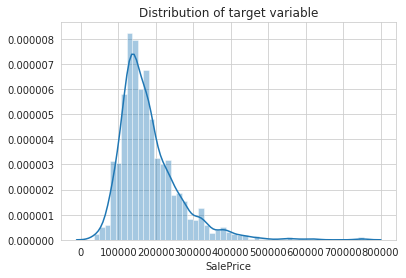

In [8]:
sns.distplot(train['SalePrice']).set_title("Distribution of target variable")
plt.show()

This is a regression problem. The distribution of the target variable sales price is highly right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed. Let's use log transform.

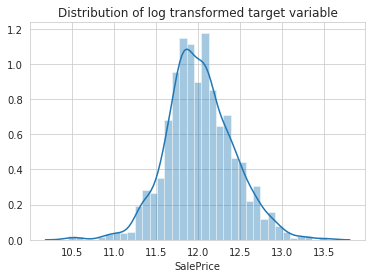

In [9]:
all_data["SalePrice"] = np.log1p(all_data["SalePrice"])
sns.distplot(all_data['SalePrice']).set_title("Distribution of log transformed target variable")
plt.show()


In [0]:
def scatterplot(x, y='SalePrice', data=train, hue=None):
  ax = sns.scatterplot(x=x, y=y, hue=hue, data=data).set_title(x)
  return ax
def boxplot(x, y='SalePrice', data=train, hue=None):
  ax = sns.boxplot(x=x, y=y, hue=hue, data=data, palette="Set3")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
  ax.set_title(x)
  ax.set_xlabel('')
  return ax

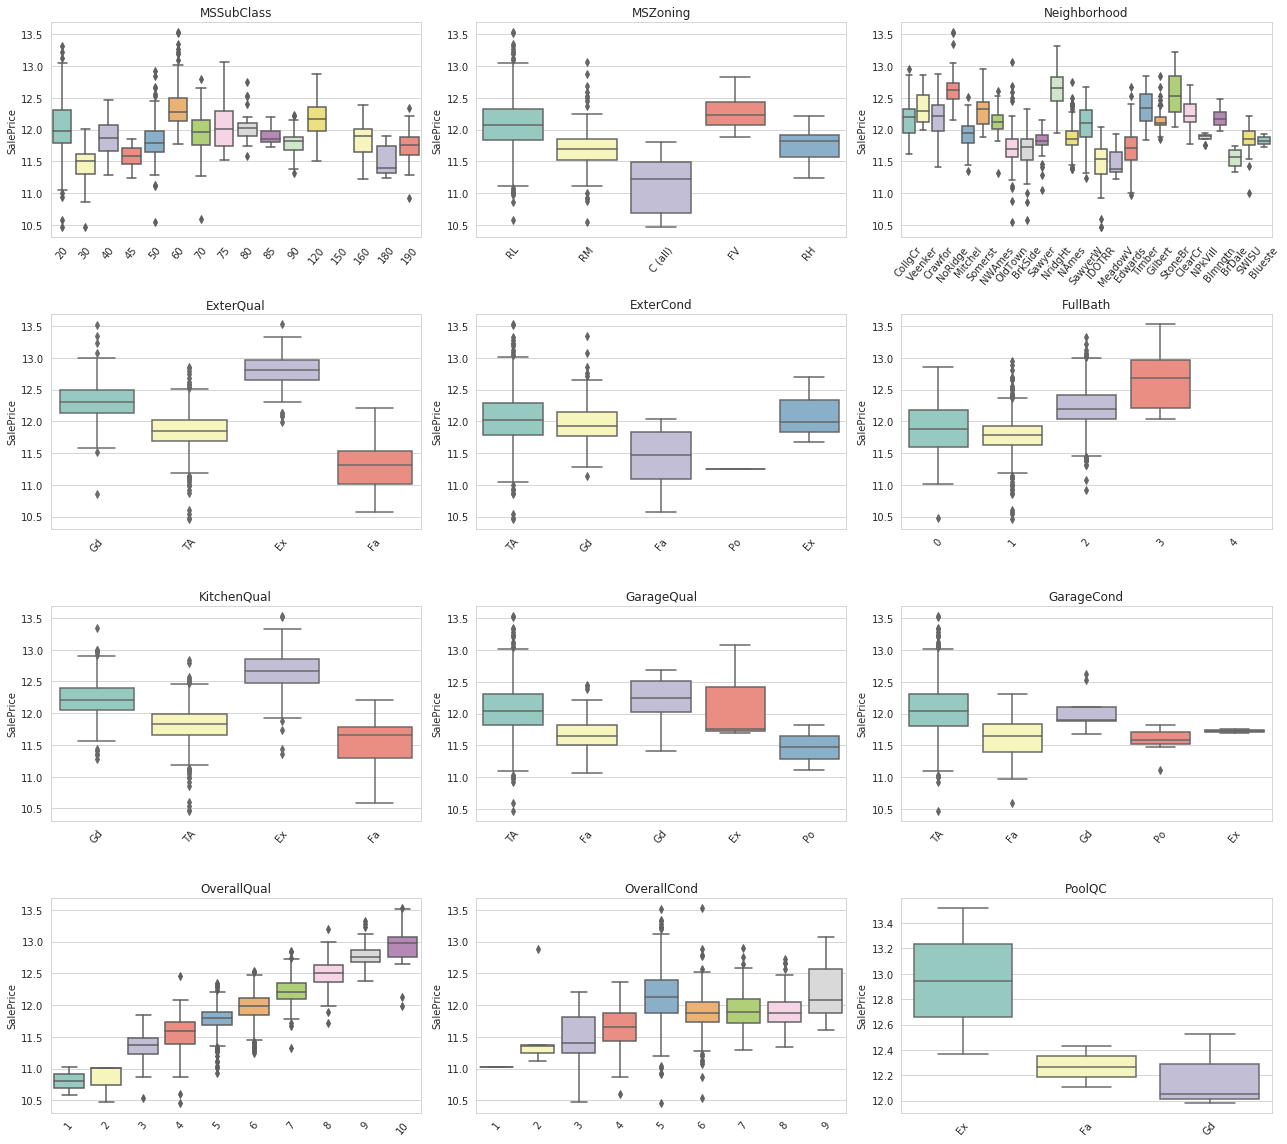

In [11]:
# Catrgorical Data
cate_lst = ['MSSubClass', 'MSZoning', 'Neighborhood',
            'ExterQual', 'ExterCond', 'FullBath',
            'KitchenQual', 'GarageQual', 'GarageCond',
            'OverallQual', 'OverallCond', 'PoolQC']
num_rows = math.ceil(len(cate_lst)/3)
fig = plt.figure(figsize=(18, 4*num_rows))
for i, cate in enumerate(cate_lst):
  fig.add_subplot(num_rows, 3, i+1)
  boxplot(x=cate, data=all_data)
fig.tight_layout()
plt.show()

#### Numerical Data

In [12]:
# Correlation matrix
corr_matrix = pd.DataFrame(train[numerical_col+['SalePrice']].corr()['SalePrice'])
corr_matrix = corr_matrix.drop('SalePrice')
corr_matrix.rename(columns = {'SalePrice':'correlation'}, inplace = True) 
# Positive correlated features
pos_cols = corr_matrix.sort_values(by='correlation', ascending=False).head(5)
display(pos_cols)
# Negative correlated features
neg_cols = corr_matrix.sort_values(by='correlation', ascending=False).tail(5)
display(neg_cols)

,correlation
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581


,correlation
YrSold,-0.028923
OverallCond,-0.077856
MSSubClass,-0.084284
EnclosedPorch,-0.128578
KitchenAbvGr,-0.135907


NameError: ignored

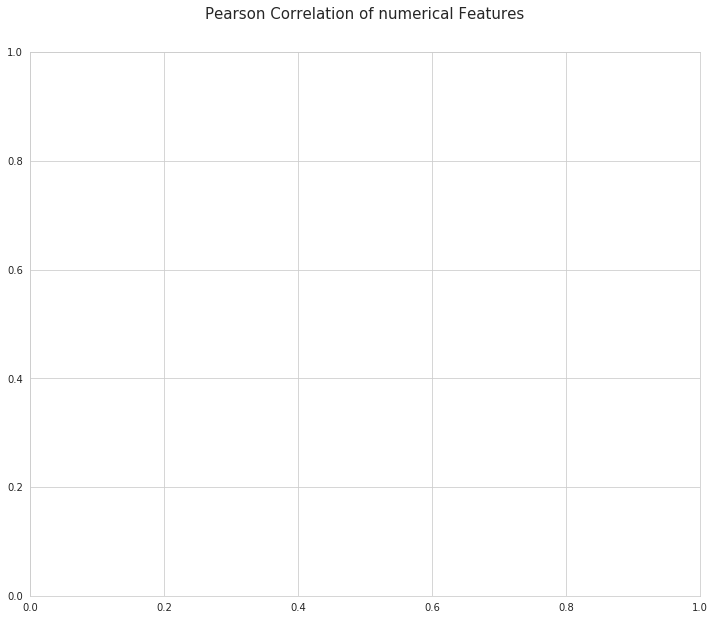

In [13]:
# Correlation matrix
plt.figure(figsize=(12, 10))
plt.title('Pearson Correlation of numerical Features', y=1.05, size=15)
tmp = all_data[num_lst+['SalePrice']].copy()
sns.heatmap(tmp.corr(), linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.show()

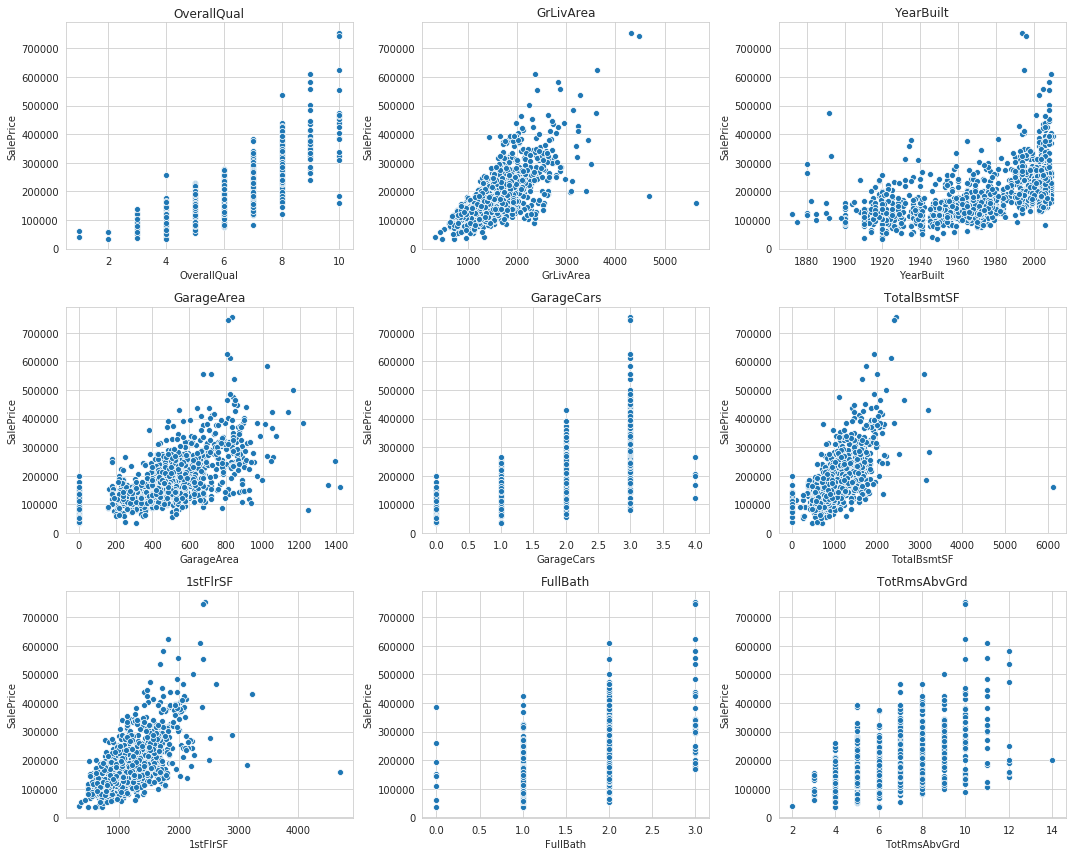

In [14]:
# Numerical Data
num_lst = ['OverallQual', 'GrLivArea', 'YearBuilt',
            'GarageArea',  'GarageCars', 'TotalBsmtSF',
            '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
num_rows = math.ceil(len(num_lst)/3)
fig = plt.figure(figsize=(15, 4*num_rows))
for i, cate in enumerate(num_lst):
  fig.add_subplot(num_rows, 3, i+1)
  scatterplot(x=cate)
fig.tight_layout()
plt.show()

#### I. check for outliers

Wait, there is a very suspecious data with very large GrLivArea but very cheap price. Let's take a closer look. Also, in the 1stFlrSF v.s. SalePrice plot, there is one have over 4000 SF but very cheap.


In [15]:
train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,...,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,...,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [0]:
all_data = all_data.drop([523, 1298])
train = train.drop([523, 1298])

These two are actually the same data. We can safely delete it

#### II. check and fill missing data

In [17]:
# Check for missing data
def check_missing(data):
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
  missing_value_df = missing_value_df[missing_value_df['percent_missing'] > 0]
  return missing_value_df.sort_values('percent_missing', ascending=False)
missing_train = check_missing(train)
missing_test = check_missing(test)
display(missing_train)
display(missing_test)

,percent_missing
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageType,5.555556
GarageYrBlt,5.555556
GarageFinish,5.555556
GarageQual,5.555556


,percent_missing
SalePrice,100.000000
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageCond,5.346127
GarageYrBlt,5.346127
GarageFinish,5.346127


In [18]:
missing_train_cols = list(missing_train.index)
missing_test_cols = list(missing_test.index)
print('%.f features have missing value in training set' % (len(missing_train_cols)))
print('%.f features have missing value in training set' % (len(missing_test_cols)-1))

19 features have missing value in training set
33 features have missing value in training set


Sometime the data is missing is not because it's missing, but not exist.
> **PoolQC:** data description says NA means "No Pool". <br>
> **MiscFeature:** data description says NA means "no misc feature" <br>
> **Alley:** data description says NA means "no alley access" <br>
> **Fence:** data description says NA means "no fence" <br>
> **FireplaceQu:** data description says NA means "no fireplace" <br>
> **BsmtUnfSF, BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2, BsmtFinSF2, BsmtFinSF1, BsmtExposure, BsmtFullBath, BsmtHalfBath, TotalBsmtSF**: NaN means that there is no basement.<br>
> **GarageCond, GarageType, GarageQual, GarageYrBlt, GarageArea,GarageCars:** NAN meanas no garage for this building.<br>
> **MasVnrArea, MasVnrType:** NAN most likely means no masonry veneer for these houses.<br>
> **MSSubClass:** NAN most likely means No building class.


In [0]:
def missing_to_none(data, feature):
  if feature in ordinal_cate_col + norminal_cate_col:
    data[feature] = data[feature].fillna('No')
  elif feature in numerical_col:
    data[feature] = data[feature].fillna(0)
  return data

for feature in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                'FireplaceQu', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF',	
                'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtFinSF1',
                'GarageCond', 'GarageType', 'GarageQual', 'GarageYrBlt', 'GarageArea',
                'GarageCars', 'GarageFinish', 'MasVnrType', 'MasVnrArea', 'MSSubClass']:
    all_data = missing_to_none(all_data, feature)

> **LotFrontage:** Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.<br>
> **Functional:** data description says NA means typical, replace by 'Typ'<br>
> **MSZoning:** 'RL' is by far the most common value. So we can fill in missing values with 'RL'. <br>
> **Utilities:** For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.<br>
> **Electrical:** It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.<br>
> **KitchenQual:** Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for its missing value.<br>
> **Exterior1st and Exterior2nd:** Again Both Exterior 1 & 2 have only one missing value. We can fill the mode value.




In [0]:
neigh_lot = all_data.groupby('Neighborhood').median()['LotFrontage']
all_data['LotFrontage'] = all_data.apply(lambda row: neigh_lot[row['Neighborhood']]
                          if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1) 
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data = all_data.drop('Utilities', axis=1)

def missing_to_mid(data, feature):
  if feature in ordinal_cate_col + norminal_cate_col:
    data[feature] = data[feature].fillna(mode(data[feature]))
  elif feature in numerical_col:
    data[feature] = data[feature].fillna(median(data[feature]))
  return data

for feature in ['MSZoning', 'Electrical', 'KitchenQual', 
                  'SaleType', 'Exterior1st', 'Exterior2nd']:
    all_data = missing_to_mid(all_data, feature)

Done! Let's double check all the missing value has been fixed except cabin (We gonna delete it).

In [21]:
 check_missing(all_data)

,percent_missing
SalePrice,50.017141


#### III. Feature Construction

In [0]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### IV. Converting 

In [0]:
# 'Alley', 'GarageType', 'MiscFeature'  NA is no

cleanup_nums = {'LotShape': {'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1},
                'LandContour': {'Lvl':4, 'Bnk':3, 'HLS':2, 'Low':1},
                'LandSlope': {'Gtl':3, 'Mod':2, 'Sev':1},
                'ExterQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                'ExterCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                'BsmtQual': {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'No':1}, # NA is no
                'BsmtCond': {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'No':1}, # NA is no
                'BsmtExposure': {'Gd':4, 'Av':3, 'Mn':2, 'No':1}, # Na is no
                'BsmtFinType1': {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'No':1}, # Na is no
                'BsmtFinType2': {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'No':1}, # Na is no
                'Functional':{'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1},
                'HeatingQC': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}, 
                'CentralAir': {'Y':2, 'N':1}, 
                'KitchenQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                'FireplaceQu': {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'No':1}, # Na is no
                'GarageFinish': {'Fin':4, 'RFn':3, 'Unf':2, 'No':1}, # Na is no
                'GarageQual': {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'No':1}, # Na is no
                'GarageCond': {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'No':1}, # Na is no
                'PavedDrive': {'Y':3, 'P':2, 'N':1},
                'PoolQC': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'No':1}, # Na is no
                'Fence': {'GdPrv':5, 'MnPrv':4, 'GdWo':3, 'MnWw':2, 'No':1} # Na is no
               }

all_data.replace(cleanup_nums, inplace=True)

In [24]:
numeric_feats = list(all_data.dtypes[all_data.dtypes != "object"].index)
numeric_feats.remove('SalePrice')
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features:")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Skew in numerical features:


,Skew
MiscVal,21.939672
PoolQC,19.110837
PoolArea,16.892477
LotArea,12.824109
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002718
ScreenPorch,3.945101


In [25]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 55 skewed numerical features to Box Cox transform


In [0]:
all_data = pd.get_dummies(all_data)
train = all_data.loc[train_id].drop([523, 1298])
test = all_data.loc[test_id].drop('SalePrice', axis=1)

In [27]:
train.shape

(1458, 235)

Now the data is cleaned, time to build some models.
### Modelling

In [0]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

In [0]:
class Ensemble_reg(object):

    def __init__(self, reg, params, cv=3, n_iter=20, 
                 scoring="neg_mean_squared_error", seed=0):
        self.reg = reg
        self.params = params
        self.n_iter = n_iter
        self.cv = cv 
        self.scoring = scoring
        self.seed = seed
        self.clf_CV = None

    def fit(self, X_train, y_train):

        '''The parameters of the estimator used to apply these methods are optimized 
        by cross-validated search over parameter settings. Given a positive cv argument, 
        if the estimator is a classifier and y is either binary or multiclass, 
        StratifiedKFold is used. '''

        self.reg_CV = RandomizedSearchCV(estimator = self.reg, 
                                         param_distributions = self.params, 
                                         n_iter = self.n_iter, cv = self.cv, 
                                         scoring = self.scoring, verbose=0)
        self.reg_CV.fit(X_train, y_train)

    def predict(self, X):
        return self.reg_CV.best_estimator_.predict(X)
    
    def get_score(self):
        return self.reg_CV.best_score_
 
    def get_feature_importances(self): 
        # This method can't be used for Logistic regression, SVM, KNN models
        estimator= self.reg_CV.best_estimator_
        importances = estimator.feature_importances_
        return importances

In [0]:
lasso = Lasso()
enet = ElasticNet()
krr = KernelRidge()
rf = RandomForestRegressor()
gboost = GradientBoostingRegressor()
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

In [0]:
# Parmeters for Randomized seaching CV

param_lasso = {'alpha': stats.uniform(0, 1),
               'max_iter': stats.randint(50, 300)}

param_enet = {'l1_ratio': stats.uniform(0, 1),
             'max_iter': stats.randint(50, 300)}

param_krr = {'alpha': stats.uniform(0, 1),
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

param_rf = {'n_estimators': stats.randint(50, 300),
            'max_depth': stats.randint(3, 6)}

param_xgb = {'n_estimators': stats.randint(50, 200),
             'eta': stats.uniform(0.01, 0.1),
             'max_depth': stats.randint(3, 6),
             'subsample': stats.uniform(0.4, 0.6),
             'colsample_bylevel': stats.uniform(0.4, 0.6)}    

param_gboost = {'learning_rate': stats.uniform(0.01, 0.1),
                'max_depth': stats.randint(3, 6),
                'n_estimators': stats.randint(50, 200),
                'subsample': stats.uniform(0.4, 0.6),
                'max_features': ['sqrt', 'auto']}

In [0]:
def train_ensemble(X, y):

    reg_lasso = Ensemble_reg(reg=lasso, params=param_lasso)
    reg_enet = Ensemble_reg(reg=enet, params=param_enet)
    reg_krr = Ensemble_reg(reg=krr, params=param_krr)
    reg_rf = Ensemble_reg(reg=rf, params=param_rf)
    reg_gboost = Ensemble_reg(reg=gboost, params=param_gboost)
    reg_xgb = Ensemble_reg(reg=xgb_reg, params=param_xgb)

    reg_lasso.fit(X, y)
    reg_enet.fit(X, y)
    reg_krr.fit(X, y)
    reg_rf.fit(X, y)
    reg_gboost.fit(X, y)
    reg_xgb.fit(X, y)
    
    fitted_models = (reg_lasso, reg_enet, reg_krr, reg_rf, reg_gboost, reg_xgb)
    
    return fitted_models

def eval_ensemble(fitted_models, cols):

    (reg_lasso, reg_enet, reg_krr, reg_rf, reg_gboost, reg_xgb) = fitted_models  
    
    best_score_df = pd.DataFrame( {
        'Lasso': reg_lasso.get_score(),
        'Enet': reg_enet.get_score(),
        'KRR': reg_krr.get_score(),
        'Random Forest': reg_rf.get_score(),
        'Gboost': reg_gboost.get_score(),
        'XGBoost': reg_xgb.get_score()
        }, index=['neg_mean_squared_error']).T
    
    rf_feature = reg_rf.get_feature_importances()
    gboost_feature = reg_gboost.get_feature_importances()
    xgb_feature = reg_xgb.get_feature_importances()

    # Create a dataframe with features
    feature_dataframe = pd.DataFrame( {'features': cols,
        'Random Forest': rf_feature,
        'GBoost': gboost_feature,
        'XGBoost': xgb_feature,
        })
    feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
    
    return best_score_df, feature_dataframe
  
def plot_feature_importance(importances, X):

   # Plot the feature importances of the model
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize = (20, 5))
    plt.title("Feature importances")
    ax = sns.barplot(x=list(range(X.shape[1])), y=np.array(importances)[indices])
    ax.set_xticklabels(rotation=30, labels=X.columns[indices])
    plt.show()

In [0]:
X, y = train.drop('SalePrice', axis=1), train['SalePrice'].copy()
cols = X.columns
scaled_X = X.copy()
scaler = MaxAbsScaler()  # This scaler is for sparse dataset
scaled_X = scaler.fit_transform(scaled_X)
scaled_test = scaler.transform(test)

fitted_models = train_ensemble(scaled_X, y)
best_score_df, feature_dataframe = eval_ensemble(fitted_models, cols)

# display(best_score_df)
# plot_feature_importance(feature_dataframe['mean'], X)

In [34]:
display(best_score_df)

,neg_mean_squared_error
Lasso,-0.102398
Enet,-0.125515
KRR,-0.017969
Random Forest,-0.025323
Gboost,-0.016418
XGBoost,-0.015732


In [0]:
def predict(fitted_models, test_data):

    (reg_lasso, reg_enet, reg_krr, reg_rf, reg_gboost, reg_xgb) = fitted_models  
    # pred_lasso = np.exp(reg_lasso.predict(test_data))
    # pred_enet = np.exp(reg_enet.predict(test_data))
    pred_krr = np.exp(reg_krr.predict(test_data))
    pred_rf = np.exp(reg_rf.predict(test_data))
    pred_gboost = np.exp(reg_gboost.predict(test_data))
    pred_xgb = np.exp(reg_xgb.predict(test_data))
    result = pd.DataFrame(( pred_krr + # pred_enet + pred_lasso + 
                            pred_rf + pred_xgb + pred_gboost) / 4,
                            index=test.index, columns=['SalePrice'])
    return result

In [39]:
result = predict(fitted_models, scaled_test)
result.head()

,SalePrice
Id,
1461,123022.259068
1462,157407.014862
1463,182194.911601
1464,187616.763323
1465,196656.072708


In [0]:
result.to_csv('2020021302.csv')